In [1]:
from math import sqrt

import numpy as np
import pandas as pd

from keras.layers import Dense, LSTM
from keras.models import Sequential

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
def parse_date(d):
    return pd.datetime.strptime('190' + d, '%Y-%m')

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


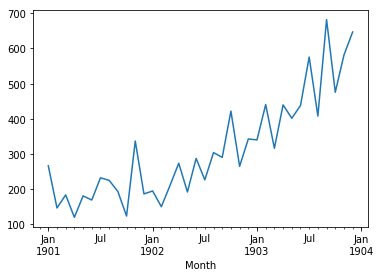

In [3]:
series = pd.read_csv('sales-of-shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parse_date)

print(series.head())

series.plot()
pyplot.show()

In [4]:
def stationarify(values, intervals=1):
    return pd.Series(values[intervals:] - values[:-intervals])


def inverse_stationary(history, y_pred, intervals=1):
    return y_pred + history[-intervals]

In [5]:
stationary = stationarify(series.values, intervals=1)
print stationary

0    -120.1
1      37.2
2     -63.8
3      61.0
4     -11.8
5      63.3
6      -7.3
7     -31.7
8     -69.9
9     213.6
10   -150.6
11      8.4
12    -44.8
13     60.6
14     63.2
15    -81.9
16     95.6
17    -61.0
18     77.6
19    -13.7
20    131.7
21   -157.1
22     77.8
23     -2.6
24    100.7
25   -124.5
26    123.4
27    -38.0
28     36.1
29    138.1
30   -167.9
31    274.4
32   -206.7
33    106.0
34     65.6
dtype: float64


In [6]:
def shift(values, steps=1):
    df = pd.DataFrame(values)
    columns = [df.shift(i) for i in range(1, steps + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [7]:
shifted = shift(stationary, steps=1)
print shifted

        0      0
0     0.0 -120.1
1  -120.1   37.2
2    37.2  -63.8
3   -63.8   61.0
4    61.0  -11.8
5   -11.8   63.3
6    63.3   -7.3
7    -7.3  -31.7
8   -31.7  -69.9
9   -69.9  213.6
10  213.6 -150.6
11 -150.6    8.4
12    8.4  -44.8
13  -44.8   60.6
14   60.6   63.2
15   63.2  -81.9
16  -81.9   95.6
17   95.6  -61.0
18  -61.0   77.6
19   77.6  -13.7
20  -13.7  131.7
21  131.7 -157.1
22 -157.1   77.8
23   77.8   -2.6
24   -2.6  100.7
25  100.7 -124.5
26 -124.5  123.4
27  123.4  -38.0
28  -38.0   36.1
29   36.1  138.1
30  138.1 -167.9
31 -167.9  274.4
32  274.4 -206.7
33 -206.7  106.0
34  106.0   65.6


In [8]:
train, test = shifted.iloc[:-12], shifted.iloc[-12:]

In [9]:
def scale(scaler, df):
    return scaler.transform(df.values.reshape(df.shape[0], df.shape[1]))


def invert_scale(scaler, X, value):
    array = np.array(list(X) + [value])
    inverted = scaler.inverse_transform(array.reshape(1, len(array)))
    return inverted[0, -1]

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train, test = scale(scaler, train), scale(scaler, test)

In [11]:
def fit(train, batch_size, epochs, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(epochs):
        if i % 50 == 0:
            print 'Epoch {}'.format(i + 1)
            
        model.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False, verbose=0)  # PITFALL: shuffle=False, model.reset_states()
        model.reset_states()

    return model


def predict(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    y_pred = model.predict(X, batch_size=batch_size)
    return y_pred[0, 0]

In [12]:
model = fit(train, 1, 1000, 4)  # PITFALL: build state!

Epoch 1
Epoch 51
Epoch 101
Epoch 151
Epoch 201
Epoch 251
Epoch 301
Epoch 351
Epoch 401
Epoch 451
Epoch 501
Epoch 551
Epoch 601
Epoch 651
Epoch 701
Epoch 751
Epoch 801
Epoch 851
Epoch 901
Epoch 951


In [13]:
model.predict(train[:, 0].reshape(len(train), 1, 1), batch_size=1)  # PITFALL: build state!

array([[-0.785716  ],
       [-0.09668589],
       [-0.44833079],
       [ 0.0844599 ],
       [-0.38223404],
       [-0.06978911],
       [-0.46161225],
       [-0.14000559],
       [ 0.14877546],
       [ 0.57652193],
       [-0.99733305],
       [ 0.14686477],
       [ 0.00965679],
       [ 0.40922481],
       [-0.05117717],
       [-0.34371233],
       [ 0.33843893],
       [-0.39896035],
       [ 0.25373596],
       [-0.33074656],
       [ 0.04295874],
       [-0.88144445],
       [ 0.17202318]], dtype=float32)

In [14]:
predictions = []

for i in range(len(test)):
    X, y = test[i, 0:-1], test[i, -1]
    
    y_pred = predict(model, 1, X)
    y_pred = invert_scale(scaler, X, y_pred)
    y_pred = inverse_stationary(series.values, y_pred, len(test) + 1 - i)
    
    predictions.append(y_pred)
    expected = series.values[len(train) + i + 1]
    
    print('Month=%d, Predicted=%f, Expected=%f' % (i + 1, y_pred, expected))

Month=1, Predicted=283.836024, Expected=339.700000
Month=2, Predicted=342.030666, Expected=440.400000
Month=3, Predicted=323.461117, Expected=315.900000
Month=4, Predicted=371.446422, Expected=439.300000
Month=5, Predicted=320.868437, Expected=401.300000
Month=6, Predicted=407.202825, Expected=437.400000
Month=7, Predicted=406.215896, Expected=575.500000
Month=8, Predicted=394.068345, Expected=407.600000
Month=9, Predicted=434.093755, Expected=682.000000
Month=10, Predicted=396.562736, Expected=475.300000
Month=11, Predicted=465.712125, Expected=581.300000
Month=12, Predicted=423.069001, Expected=646.900000


In [15]:
rmse = sqrt(mse(series.values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 124.096


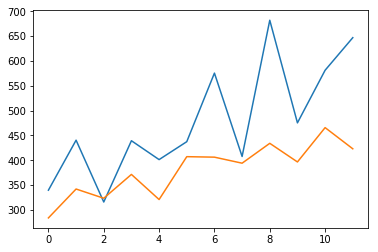

In [16]:
pyplot.plot(series.values[-12:])
pyplot.plot(predictions)
pyplot.show()